In [22]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                logs/           ML.ipynb      scripts/
DeadReckoning.ipynb  makedata.ipynb  model/        Untitled0.ipynb
graph/               ML2.ipynb       others/
loaddata.ipynb       ML_angle.ipynb  __pycache__/


In [0]:
# !pip install --upgrade tensorflow

In [0]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error

plt.style.use('ggplot')

In [0]:
# def load_data(filename):
#     data = np.loadtxt(filename, delimiter=',', skiprows=1,
#                       unpack=False, dtype=str)
#     speed = data[:, 1].astype('f8')
#     speed = speed[:, np.newaxis]
#     acc = data[:, 2: 2+3*50]
#     return acc, speed

def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    speed = []
    xyzwave = []
    for row in data:
        speed.append(row[1].astype('f8'))
        xyzwave.append(row[2: 2 + 3*50].astype('f8'))
    speed = np.array(speed)
    x = np.array(xyzwave)
    t = speed[:, np.newaxis]
    return x, t

In [0]:
# データの読み込み
x1, t1 = load_data('data/191106_1152/ML.csv')
x2, t2 = load_data('data/191121_1625/ML.csv')
x3, t3 = load_data('data/191204_1956/ML.csv')
x = np.concatenate([x1, x2, x3], axis=0)
t = np.concatenate([t1, t2, t3], axis=0)

SPEED_MAX = 2.5
t /= SPEED_MAX 

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1)

In [0]:
# ハイパーパラメータ
activation = 'tanh'
activation_output = 'sigmoid'
learning_rate = 0.001
batch_size = 32
optimizer = 'adam'
loss = 'mse'

In [28]:
import keras.backend as K
K.clear_session()

# モデル生成
model = keras.models.Sequential([
    layers.Input(shape=(150,)),
    # layers.Dropout(0.2),
    layers.Dense(100, activation=activation),
    layers.Dense( 50, activation=activation),
    layers.Dense( 25, activation=activation),
    layers.Dense( 12, activation=activation),
    layers.Dense(  1, activation=activation_output)
])

adam = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam, loss=loss, metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 21,750
Trainable params: 21,750
Non-trainable params: 0
_________________________________________________________________


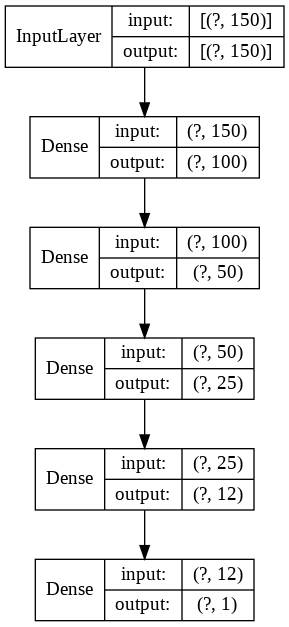

In [29]:
# モデル可視化
keras.utils.plot_model(model, to_file='graph/model.png',
                       show_shapes=True, show_layer_names=False)

In [30]:
# 学習
logdir = 'logs/ML/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=True)
result = model.fit(x_train, t_train, epochs=100,
                   batch_size=batch_size,
                   callbacks=[tensorboard_callback],
                   validation_data=(x_test, t_test))

Epoch 1/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0167 - mae: 0.1013 - val_loss: 0.0091 - val_mae: 0.0707
Epoch 2/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0069 - mae: 0.0628 - val_loss: 0.0057 - val_mae: 0.0559
Epoch 3/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0042 - mae: 0.0480 - val_loss: 0.0038 - val_mae: 0.0436
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0426 - val_loss: 0.0032 - val_mae: 0.0413
Epoch 5/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0391 - val_loss: 0.0026 - val_mae: 0.0374
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0354 - val_loss: 0.0024 - val_mae: 0.0370
Epoch 7/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0020 - mae: 0.0336 - val_loss: 0.0021 - val_mae: 0.0349
Epoch 8/100
92/92 [==============================] - 0s 4ms/step - loss: 0.0019 - m

In [0]:
# モデルの保存
# model.save('model/my_model.h5')

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open('model/converted_model.tflite', 'wb').write(tflite_model)

In [0]:
# テスト
y_train = model.predict(x_train)
t_train *= SPEED_MAX
y_train *= SPEED_MAX

y_test = model.predict(x_test)
t_test *= SPEED_MAX
y_test *= SPEED_MAX

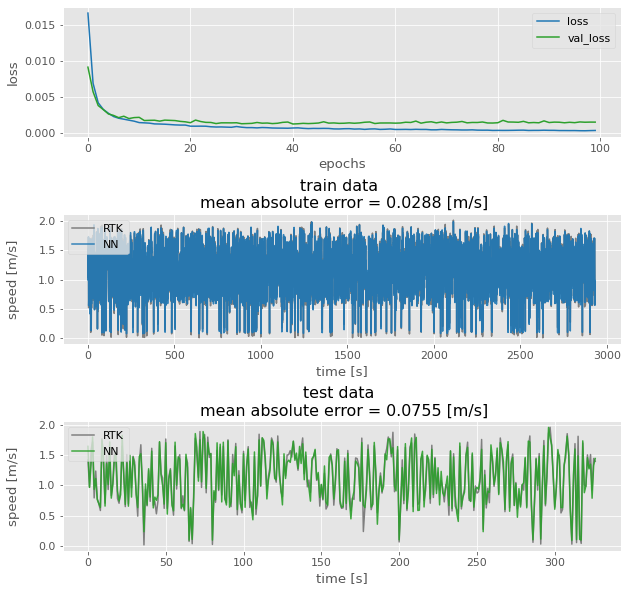

In [33]:
def plot_result():
    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(311)
    # ax1.set_title('activation={}, '.format(activation) + 
    #                 'activation_output={}, \n'.format(activation_output) + 
    #                 'learning_rate={}, '.format(learning_rate) +
    #                 'optimizer={}, '.format(optimizer) + 
    #                 'loss={}'.format(loss))
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.plot(result.history['loss'], color='tab:blue', label='loss')
    ax1.plot(result.history['val_loss'], color='tab:green', label='val_loss')
    ax1.legend(loc='upper right')

    ax2 = fig.add_subplot(312)
    mae_train = mean_absolute_error(t_train, y_train)
    ax2.set_title('train data \n mean absolute error = {0:.3} [m/s]' \
                  .format(mae_train))
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('speed [m/s]')
    ax2.plot(t_train, color='tab:gray', label='RTK')
    ax2.plot(y_train, color='tab:blue', label='NN', alpha=0.9)
    ax2.legend(loc='upper left')

    ax3 = fig.add_subplot(313)
    mae_test = mean_absolute_error(t_test, y_test)
    ax3.set_title('test data \n mean absolute error = {0:.3} [m/s]' \
                  .format(mae_test))
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('speed [m/s]')
    ax3.plot(t_test, color='tab:gray', label='RTK')
    ax3.plot(y_test, color='tab:green', label='NN', alpha=0.9)
    ax3.legend(loc='upper left')

    fig.align_labels()
    fig.subplots_adjust(hspace=0.6)
    # fig.savefig('graph/graph.png')

# 学習結果
plt.rcParams['font.size'] = 11
plot_result()

In [0]:
def test(filename: str):
    x, t = load_data(filename)
    y = model.predict(x) * SPEED_MAX
    return t, y

def plot_test(t, y):
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(111)
    mae = mean_absolute_error(t, y)
    # ax.set_title('mean absolute error = {:.3} [m/s]'.format(mae))
    ax.set_xlabel('time [s]')
    ax.set_ylabel('speed [m/s]')
    ax.plot(t, color='gray', label='RTK')
    ax.plot(y, color='tab:blue', label='NN', alpha=0.7)
    ax.legend(loc='upper left')
    print(len(t))

1860
671
715
554
663


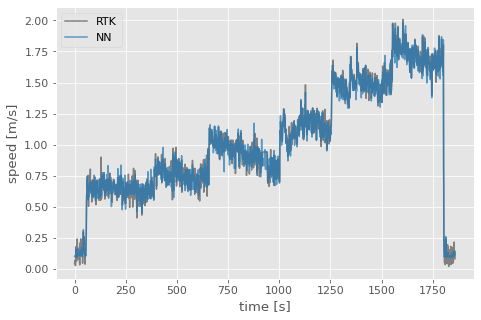

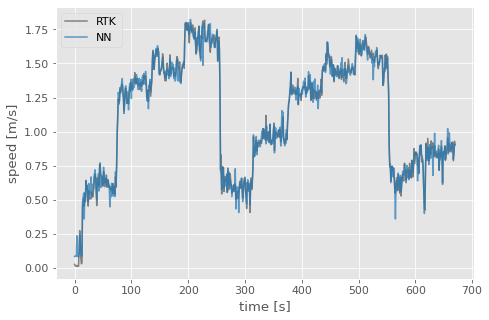

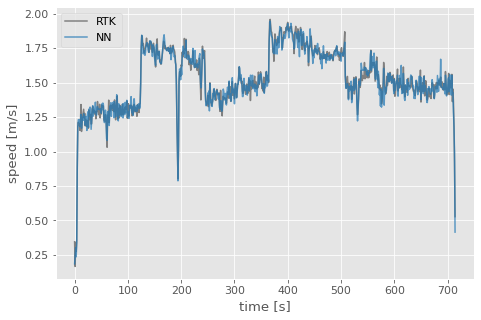

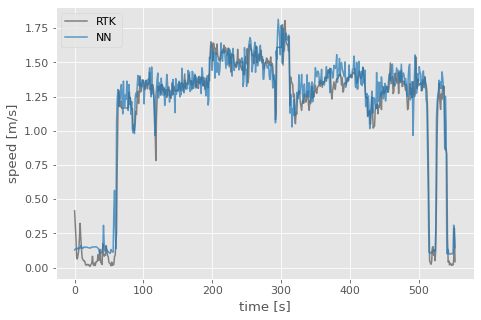

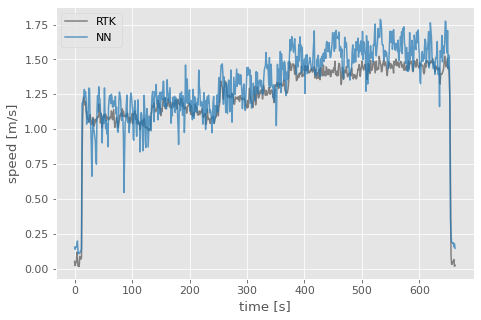

In [35]:
t, y = test('data/191121_1625/ML.csv')
plot_test(t, y)

t, y = test('data/191106_1152/ML.csv')
plot_test(t[10:-5], y[10:-5])

t, y = test('data/191204_1956/ML.csv')
plot_test(t, y)

t, y = test('data/191204_2012/ML.csv')
plot_test(t, y)

t, y = test('data/191211_1649/ML.csv')
plot_test(t[15:-5], y[15:-5])

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [37]:
%tensorboard --logdir logs/ML

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 760.